In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.loaders import load_mat_spike_data, print_data_summary
from src.generators import (
    homogeneous_poisson,
    homogeneous_poisson_with_refractoriness,
    interspike_intervals
)
from src.analysis import (
    coefficient_of_variation,
    fano_factor,
    isi_histogram,
    firing_rate_estimate
)
from src.sta import compute_sta, compute_stimulus_response_curve
from src.inhomogeneous_poisson import (
    estimate_transfer_function,
    inhomogeneous_poisson_generator,
    inhomogeneous_poisson_batch
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All imports successful!")

# Load real data
print("\n" + "="*70)
print("LOADING REAL H1 NEURON DATA")
print("="*70)

spike_times_real, stimulus, metadata = load_mat_spike_data(
    '../data/raw/c1p8.mat',
    sampling_rate=1000.0
)

print_data_summary(spike_times_real, metadata)

real_firing_rate = metadata['firing_rate']
real_duration = metadata['duration']

✓ All imports successful!

LOADING REAL H1 NEURON DATA
NEURAL RECORDING SUMMARY

File: ../data/raw/c1p8.mat
Duration: 600.0 seconds (10.00 minutes)
Sampling rate: 1000 Hz
Total samples: 600000

Spike Statistics:
  Total spikes: 53601
  Firing rate: 89.3 Hz
  Spike time range: 0.0170 to 599.9470 s

Interspike Interval Statistics:
  Mean ISI: 11.193 ms
  Min ISI: 1.000 ms
  Max ISI: 304.000 ms
  Median ISI: 4.000 ms


In [2]:
print("\n" + "="*70)
print("PART 1 & 2 RECAP: Why Simple Models Failed")
print("="*70)

# Generate simple models with constant rate
spikes_poisson = homogeneous_poisson(real_firing_rate, real_duration, random_seed=42)
spikes_refractory = homogeneous_poisson_with_refractoriness(
    real_firing_rate, real_duration, refractory_period=0.002, random_seed=42
)

# Calculate statistics
cv_real = coefficient_of_variation(spike_times_real)
cv_poisson = coefficient_of_variation(spikes_poisson)
cv_refractory = coefficient_of_variation(spikes_refractory)

ff_real_10ms = fano_factor(spike_times_real, real_duration, 0.01)
ff_poisson_10ms = fano_factor(spikes_poisson, real_duration, 0.01)
ff_refractory_10ms = fano_factor(spikes_refractory, real_duration, 0.01)

print(f"\nComparison of constant-rate models:")
print(f"\n{'Metric':<20} {'Real Data':<15} {'Poisson':<15} {'Refractory':<15}")
print("-" * 65)
print(f"{'CV':<20} {cv_real:<15.4f} {cv_poisson:<15.4f} {cv_refractory:<15.4f}")
print(f"{'FF @ 10ms':<20} {ff_real_10ms:<15.4f} {ff_poisson_10ms:<15.4f} {ff_refractory_10ms:<15.4f}")
print(f"{'Spike Count':<20} {len(spike_times_real):<15} {len(spikes_poisson):<15} {len(spikes_refractory):<15}")

print(f"\n✗ PROBLEM: Both models severely underestimate variability")
print(f"  → Real CV is 2x higher than predicted")
print(f"  → Real FF is 5x higher than predicted")
print(f"  → REASON: We ignored the stimulus!")


PART 1 & 2 RECAP: Why Simple Models Failed

Comparison of constant-rate models:

Metric               Real Data       Poisson         Refractory     
-----------------------------------------------------------------
CV                   2.0086          0.9992          0.8489         
FF @ 10ms            1.6958          0.9939          0.7385         
Spike Count          53601           53548           45485          

✗ PROBLEM: Both models severely underestimate variability
  → Real CV is 2x higher than predicted
  → Real FF is 5x higher than predicted
  → REASON: We ignored the stimulus!



EXTENSION 1: Learning from the Data

Transfer function estimated:
  Stimulus range: -157.92 to 156.17
  Minimum firing rate: 33.3 Hz
  Maximum firing rate: 131.6 Hz
  Mean firing rate: 88.2 Hz
  Rate variation: 98.2 Hz


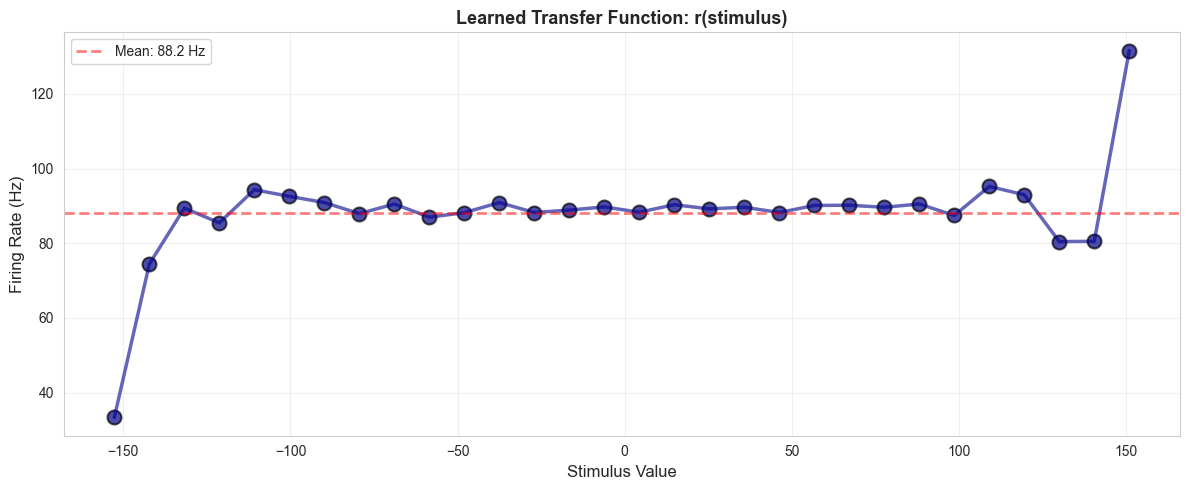


✓ Key insight: Firing rate STRONGLY depends on stimulus
  This explains the high variability in real data!


In [3]:
print("\n" + "="*70)
print("EXTENSION 1: Learning from the Data")
print("="*70)

# Estimate transfer function from real data
stim_values, firing_rates = estimate_transfer_function(
    spike_times_real,
    stimulus,
    sampling_rate=1000.0,
    n_bins=30
)

print(f"\nTransfer function estimated:")
print(f"  Stimulus range: {np.min(stimulus):.2f} to {np.max(stimulus):.2f}")
print(f"  Minimum firing rate: {np.min(firing_rates):.1f} Hz")
print(f"  Maximum firing rate: {np.max(firing_rates):.1f} Hz")
print(f"  Mean firing rate: {np.mean(firing_rates):.1f} Hz")
print(f"  Rate variation: {np.max(firing_rates) - np.min(firing_rates):.1f} Hz")

# Visualize transfer function
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(stim_values, firing_rates, s=100, alpha=0.7, color='darkblue', edgecolors='black', linewidth=1.5)
ax.plot(stim_values, firing_rates, linewidth=2.5, color='darkblue', alpha=0.6)
ax.set_xlabel("Stimulus Value", fontsize=12)
ax.set_ylabel("Firing Rate (Hz)", fontsize=12)
ax.set_title("Learned Transfer Function: r(stimulus)", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=np.mean(firing_rates), color='red', linestyle='--', alpha=0.5, linewidth=2, label=f'Mean: {np.mean(firing_rates):.1f} Hz')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/15_transfer_function.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Key insight: Firing rate STRONGLY depends on stimulus")
print(f"  This explains the high variability in real data!")

In [4]:
print("\n" + "="*70)
print("SOLUTION: Inhomogeneous Poisson Model")
print("="*70)

# Create transfer function tuple
transfer_fn = (stim_values, firing_rates)

# Generate inhomogeneous Poisson spikes
print(f"\nGenerating inhomogeneous Poisson spike train...")
spikes_inhom = inhomogeneous_poisson_generator(
    stimulus,
    transfer_fn,
    sampling_rate=1000.0,
    random_seed=42
)

print(f"✓ Generated {len(spikes_inhom)} spikes")
print(f"  Average rate: {len(spikes_inhom)/real_duration:.1f} Hz")

# Also generate multiple trials for statistics
print(f"\nGenerating 100 trials for statistical analysis...")
inhom_trials = inhomogeneous_poisson_batch(
    stimulus,
    transfer_fn,
    sampling_rate=1000.0,
    n_trials=100,
    random_seed=42
)

# Calculate statistics across trials
cv_inhom_trials = []
ff_inhom_trials = []

for trial in inhom_trials:
    cv = coefficient_of_variation(trial)
    ff = fano_factor(trial, real_duration, 0.01)
    if not np.isnan(cv):
        cv_inhom_trials.append(cv)
    if not np.isnan(ff):
        ff_inhom_trials.append(ff)

cv_inhom_trials = np.array(cv_inhom_trials)
ff_inhom_trials = np.array(ff_inhom_trials)

print(f"✓ Statistics from 100 trials:")
print(f"  Mean CV: {np.mean(cv_inhom_trials):.4f}")
print(f"  Mean FF @ 10ms: {np.mean(ff_inhom_trials):.4f}")


SOLUTION: Inhomogeneous Poisson Model

Generating inhomogeneous Poisson spike train...
✓ Generated 53569 spikes
  Average rate: 89.3 Hz

Generating 100 trials for statistical analysis...
✓ Statistics from 100 trials:
  Mean CV: 0.9549
  Mean FF @ 10ms: 0.9123


In [5]:
print("\n" + "="*70)
print("FINAL COMPARISON: Three Models vs Real Data")
print("="*70)

# Calculate statistics for all models
isis_real = interspike_intervals(spike_times_real)
isis_poisson = interspike_intervals(spikes_poisson)
isis_refractory = interspike_intervals(spikes_refractory)
isis_inhom = interspike_intervals(spikes_inhom)

ff_real_1s = fano_factor(spike_times_real, real_duration, 1.0)
ff_poisson_1s = fano_factor(spikes_poisson, real_duration, 1.0)
ff_refractory_1s = fano_factor(spikes_refractory, real_duration, 1.0)
ff_inhom_1s = fano_factor(spikes_inhom, real_duration, 1.0)

# Comprehensive comparison table
print(f"\n{'Metric':<20} {'Real':<12} {'Poisson':<12} {'Refract':<12} {'Inhom':<12}")
print("-" * 68)
print(f"{'Spike Count':<20} {len(spike_times_real):<12} {len(spikes_poisson):<12} {len(spikes_refractory):<12} {len(spikes_inhom):<12}")
print(f"{'Firing Rate (Hz)':<20} {real_firing_rate:<12.1f} {len(spikes_poisson)/real_duration:<12.1f} {len(spikes_refractory)/real_duration:<12.1f} {len(spikes_inhom)/real_duration:<12.1f}")
print(f"{'CV':<20} {cv_real:<12.4f} {cv_poisson:<12.4f} {cv_refractory:<12.4f} {np.mean(cv_inhom_trials):<12.4f}")
print(f"{'Min ISI (ms)':<20} {np.min(isis_real)*1000:<12.3f} {np.min(isis_poisson)*1000:<12.3f} {np.min(isis_refractory)*1000:<12.3f} {np.min(isis_inhom)*1000:<12.3f}")
print(f"{'Mean ISI (ms)':<20} {np.mean(isis_real)*1000:<12.3f} {np.mean(isis_poisson)*1000:<12.3f} {np.mean(isis_refractory)*1000:<12.3f} {np.mean(isis_inhom)*1000:<12.3f}")
print(f"{'FF @ 10ms':<20} {ff_real_10ms:<12.4f} {ff_poisson_10ms:<12.4f} {ff_refractory_10ms:<12.4f} {np.mean(ff_inhom_trials):<12.4f}")
print(f"{'FF @ 1s':<20} {ff_real_1s:<12.4f} {ff_poisson_1s:<12.4f} {ff_refractory_1s:<12.4f} {ff_inhom_1s:<12.4f}")

# Calculate errors
cv_error_p = abs(cv_poisson - cv_real)
cv_error_r = abs(cv_refractory - cv_real)
cv_error_i = abs(np.mean(cv_inhom_trials) - cv_real)

ff_error_p = abs(ff_poisson_10ms - ff_real_10ms)
ff_error_r = abs(ff_refractory_10ms - ff_real_10ms)
ff_error_i = abs(np.mean(ff_inhom_trials) - ff_real_10ms)

total_error_p = cv_error_p + ff_error_p
total_error_r = cv_error_r + ff_error_r
total_error_i = cv_error_i + ff_error_i

print(f"\n{'ERROR from Real Data':<20} {'Poisson':<12} {'Refract':<12} {'Inhom':<12}")
print("-" * 68)
print(f"{'CV Error':<20} {cv_error_p:<12.4f} {cv_error_r:<12.4f} {cv_error_i:<12.4f}")
print(f"{'FF Error':<20} {ff_error_p:<12.4f} {ff_error_r:<12.4f} {ff_error_i:<12.4f}")
print(f"{'TOTAL ERROR':<20} {total_error_p:<12.4f} {total_error_r:<12.4f} {total_error_i:<12.4f}")

print(f"\n✓ BEST MODEL: ", end="")
errors = [total_error_p, total_error_r, total_error_i]
models = ["Poisson", "Refractory", "Inhomogeneous Poisson"]
best_idx = np.argmin(errors)
print(f"{models[best_idx]}")

improvement_vs_poisson = ((total_error_p - total_error_i) / total_error_p) * 100
print(f"✓ Improvement: {improvement_vs_poisson:.1f}% better than Poisson")



FINAL COMPARISON: Three Models vs Real Data

Metric               Real         Poisson      Refract      Inhom       
--------------------------------------------------------------------
Spike Count          53601        53548        45485        53569       
Firing Rate (Hz)     89.3         89.2         75.8         89.3        
CV                   2.0086       0.9992       0.8489       0.9549      
Min ISI (ms)         1.000        0.000        2.000        1.000       
Mean ISI (ms)        11.193       11.204       13.191       11.200      
FF @ 10ms            1.6958       0.9939       0.7385       0.9123      
FF @ 1s              7.1036       0.9786       0.6835       0.8702      

ERROR from Real Data Poisson      Refract      Inhom       
--------------------------------------------------------------------
CV Error             1.0093       1.1596       1.0536      
FF Error             0.7019       0.9573       0.7835      
TOTAL ERROR          1.7113       2.1170       1.83


VISUALIZATION: How Models Differ


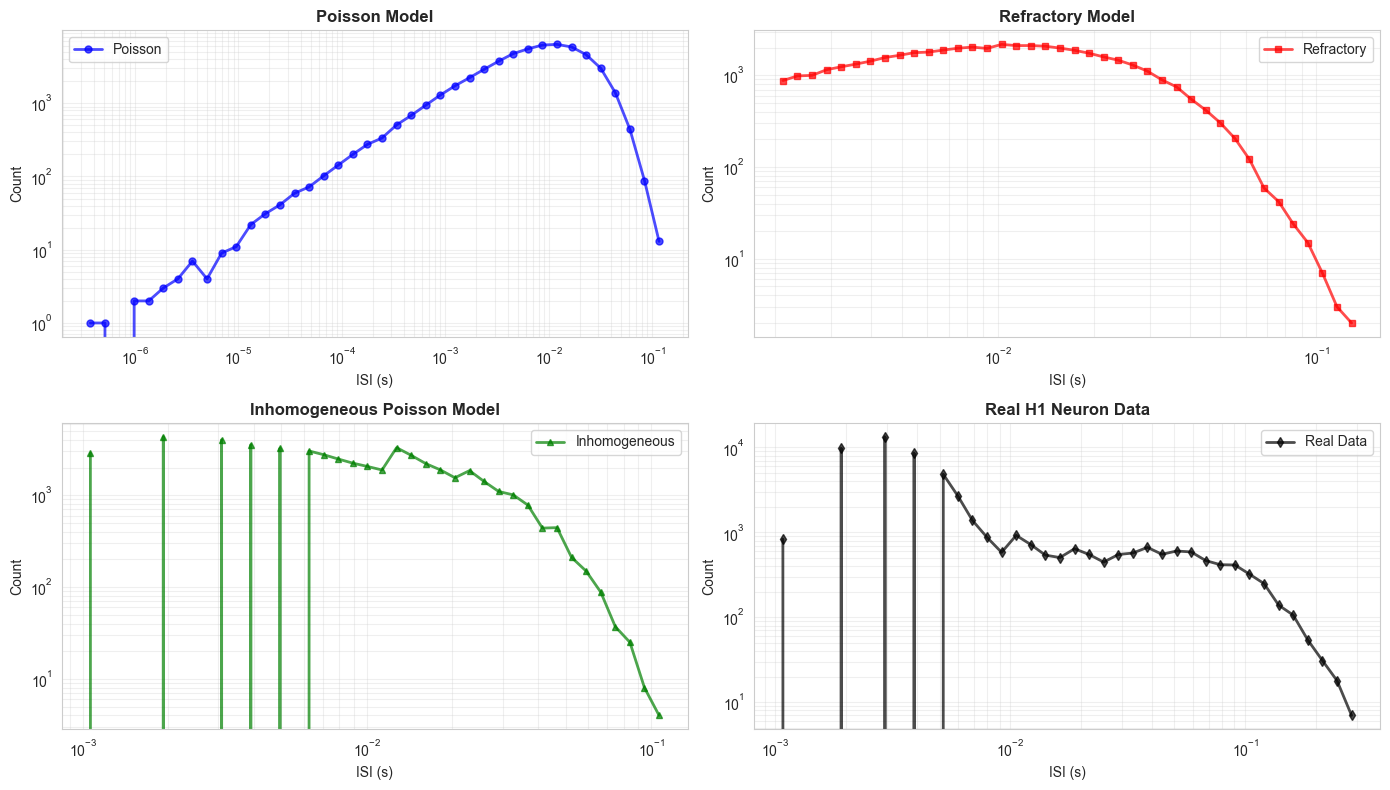

✓ ISI comparison plots saved


In [6]:
print("\n" + "="*70)
print("VISUALIZATION: How Models Differ")
print("="*70)

# Plot ISI distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Poisson ISI
ax = axes[0, 0]
hist_p, edges_p = isi_histogram(spikes_poisson, n_bins=40, log_scale=True)
bin_centers_p = (edges_p[:-1] + edges_p[1:]) / 2
ax.loglog(bin_centers_p, hist_p, 'o-', linewidth=2, markersize=5, color='blue', alpha=0.7, label='Poisson')
ax.set_title("Poisson Model", fontsize=12, fontweight='bold')
ax.set_xlabel("ISI (s)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Refractory ISI
ax = axes[0, 1]
hist_r, edges_r = isi_histogram(spikes_refractory, n_bins=40, log_scale=True)
bin_centers_r = (edges_r[:-1] + edges_r[1:]) / 2
ax.loglog(bin_centers_r, hist_r, 's-', linewidth=2, markersize=5, color='red', alpha=0.7, label='Refractory')
ax.set_title("Refractory Model", fontsize=12, fontweight='bold')
ax.set_xlabel("ISI (s)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Inhomogeneous ISI
ax = axes[1, 0]
hist_i, edges_i = isi_histogram(spikes_inhom, n_bins=40, log_scale=True)
bin_centers_i = (edges_i[:-1] + edges_i[1:]) / 2
ax.loglog(bin_centers_i, hist_i, '^-', linewidth=2, markersize=5, color='green', alpha=0.7, label='Inhomogeneous')
ax.set_title("Inhomogeneous Poisson Model", fontsize=12, fontweight='bold')
ax.set_xlabel("ISI (s)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3, which='both')
ax.legend()

# Real data ISI
ax = axes[1, 1]
hist_real, edges_real = isi_histogram(spike_times_real, n_bins=40, log_scale=True)
bin_centers_real = (edges_real[:-1] + edges_real[1:]) / 2
ax.loglog(bin_centers_real, hist_real, 'd-', linewidth=2, markersize=5, color='black', alpha=0.7, label='Real Data')
ax.set_title("Real H1 Neuron Data", fontsize=12, fontweight='bold')
ax.set_xlabel("ISI (s)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3, which='both')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/16_all_models_isi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ISI comparison plots saved")

